# Straight Shot Difficulty

Consider a straight shot into a pocket where the cue ball (CB) is a total distance $D$ from the pocket. Which object ball (OB) position (distance $d$ from the CB) results in the most difficult pot?

This question is posed by Dr. Dave Billiards in [this proof](https://billiards.colostate.edu/technical_proofs/TP_3-4.pdf) and based on the assumptions made, the answer is

$$
d = D/2
$$

In other words, the shot is made most difficult when the OB is placed equidistantly from both the pocket and the CB.

In this example, we will directly simulate straight shots and determine under what circumstances this theory holds up.

## Setting up a system

Let's set up a system where the OB is shot into a corner pocket _straight on_ (at an angle of 45 degrees from both the long cushion and short cushion).

We'll begin by creating a big square [Table](../autoapi/pooltool/index.rst#pooltool.Table) that gives us plenty of space. There are many different parameters that can be passed to [PocketTableSpecs](../autoapi/pooltool/objects/index.rst#pooltool.objects.PocketTableSpecs) that influence the shape of the pockets (you can get a visual explanation of each parameter [here](../resources/table_specs.md)), but here we will keep the default values, which are modelled after my old 7-foot Showood table with pretty wide 5 inch pockets.

In [1]:
import pooltool as pt

table_specs = pt.objects.PocketTableSpecs(l=10, w=10)
table = pt.Table.from_table_specs(table_specs)

As a reminder, $D$ represents the distance of the CB to the pocket, but let's be a little more precise with what that means. From the CB, we will measure from the ball's center, and from the pocket we will measure from pocket's edge that's closest to the CB. So when $D$ is 0, the CB is teetering on the edge of the pocket.

With that in mind, let's pick the bottom-left corner [Pocket](../autoapi/pooltool/objects/index.rst#pooltool.objects.Pocket) as our target and place a CB a distance $D$ away.

In [2]:
import numpy as np

# lb stands for left-bottom
pocket = table.pockets["lb"]

# The pocket's center is defined with 3D coordinates, but we'll just use X and Y
center = pocket.center[:2]

pocket_point = center + pocket.radius * np.sqrt(2)

print(f"The pocket point is {pocket_point}")

The pocket point is [0.0595383909759073 0.0595383909759073]


Now let's create a cue ball a distance $D$ away.

In [3]:
D = 1.0

def create_cue_ball(pocket_point, D):
    cue_point = pocket_point + D * np.sqrt(2)
    return pt.Ball.create("CB", xy=cue_point)

cue_ball = create_cue_ball(pocket_point, D)

Let's create an object ball a distance $d$ from the cue ball. In order for the object ball to be between the cue and the pocket, $d$ is constrained by

$$
2 R \lt d \lt D
$$

where $R$ is the radius of the balls.

In [4]:
def create_object_ball(cue_ball, d):
    obj_point = cue_ball.xyz[:2] - d * np.sqrt(2)
    return pt.Ball.create("OB", xy=obj_point)

d = 0.3

obj_ball = create_object_ball(cue_ball, d)

Let's go ahead and turn everything we've done into a function that takes $d$ and $D$ as parameters and returns a [System](../autoapi/pooltool/index.rst#pooltool.System).

In [5]:
def create_system(d, D):
    table_specs = pt.objects.PocketTableSpecs(l=10, w=10)
    table = pt.Table.from_table_specs(table_specs)       
    pocket = table.pockets["lb"]
    pocket_point = pocket.center[:2] + pocket.radius * np.sqrt(2)

    cue_ball = create_cue_ball(pocket_point, D)
    obj_ball = create_object_ball(cue_ball, d)

    return pt.System(
        cue=pt.Cue(cue_ball_id="CB"),
        balls=(cue_ball, obj_ball),
        table=table,
    )

With this function, we can create a system:

In [6]:
system = create_system(d, D)

If you have a graphics card, you can visualize the system in 3D with

```python
pt.show(system)
```

## Simulating a shot

No energy has been imparted into the system so it's currently rather dull. Let's change that by striking the CB in the direction of the OB.

In [7]:
# phi is the aiming direction
phi = pt.aim.at_ball(cue_ball=system.balls["CB"], object_ball=system.balls["OB"], cut=0)

# Based on the geometry, we know that phi is 225 degrees (towards the bottom-left pocket)
assert phi == 225.0

system.cue.set_state(V0=1, phi=phi, cue_ball_id="CB")

Since the pocket, OB, and CB are all lined up, this should lead to a successful pot. Let's check by simulating and filtering the system events according to our criteria.

In [8]:
pt.simulate(system, inplace=True)

def successful_pot(system) -> bool:
    # Find events that are ball-pocket events and involve the object ball
    pocket_events = pt.events.filter_events(
        system.events,
        pt.events.by_type(pt.EventType.BALL_POCKET),
        pt.events.by_ball("OB"),
    )
    return bool(len(pocket_events))    

successful_pot(system)

True

Great! As expected, it went straight in.

## Modeling imprecision

Real pool players don't have perfect precision and we are going to emulate this by introducing uncertainty into the aiming angle $\phi$. We'll call this uncertainty $d\phi$.

While we're at it, let's make a function that adds uncertainty not just to $\phi$, but to the other cue striking parameters as well, that you can read about [here](../autoapi/pooltool/index.rst#pooltool.Cue).

In [9]:
def perturb(x, dx):
    return x + dx * (2*np.random.rand() - 1)

def strike(system, V0, a, phi, theta, dV0=0, da=0, dphi=0, dtheta=0):
    system.cue.set_state(
        cue_ball_id="CB",
        V0=perturb(V0, dV0),
        a=perturb(a, da),
        phi=perturb(phi, dphi),
        theta=perturb(theta, dtheta),
    )

## Estimating Difficulty for a Given $d$

To evaluate the difficulty level associated with shot where the OB is a distance $d$ from the CB, we will calculate the fraction of successful pots (successful shots) from a set of trials. In these trials, we will introduce random perturbations to the angle $\phi$ for each shot. The perturbations are limited so that the angle $\phi$ deviates by no more than a fixed amount $d\phi$.

This means that for each shot, the angle $\phi$ is randomly adjusted within the range $[\phi - d\phi, \phi + d\phi]$. By observing how these perturbations affect the success rate, we can estimate the difficulty associated with the given $d$.

Let's pick a $d\phi$ and then simulate 100 shots.

In [10]:
dphi = 0.4  # Just 0.4 degrees!
phi = 225.0
V0 = 1.0  # 1 m/s cue-stick strike
a = 0  # No sidespin
theta = 0  # Level cue stick
d = 0.3
D = 1.0

num_trials = 100
successes = []
for _ in range(num_trials):
    system = create_system(d, D)
    strike(system, V0, a, phi, theta, dphi=dphi)
    pt.simulate(system, inplace=True)
    success = successful_pot(system)
    successes.append(success)

pot_fraction = sum(successes) / len(successes)
print(f"The success rate is {pot_fraction*100:.0f}%.")

The success rate is 44%.


## Which $d$ yields the most difficult shot?

Great. Now, we can run the same experiment, but vary $d$ to determine which yields the most difficult shot.

For d = 0.06 m, the success rate is 100%.


For d = 0.14 m, the success rate is 86%.


For d = 0.23 m, the success rate is 55%.


For d = 0.31 m, the success rate is 37%.


For d = 0.40 m, the success rate is 36%.


For d = 0.49 m, the success rate is 33%.


For d = 0.57 m, the success rate is 35%.


For d = 0.66 m, the success rate is 42%.


For d = 0.74 m, the success rate is 43%.


For d = 0.83 m, the success rate is 52%.


For d = 0.91 m, the success rate is 92%.


For d = 1.00 m, the success rate is 100%.


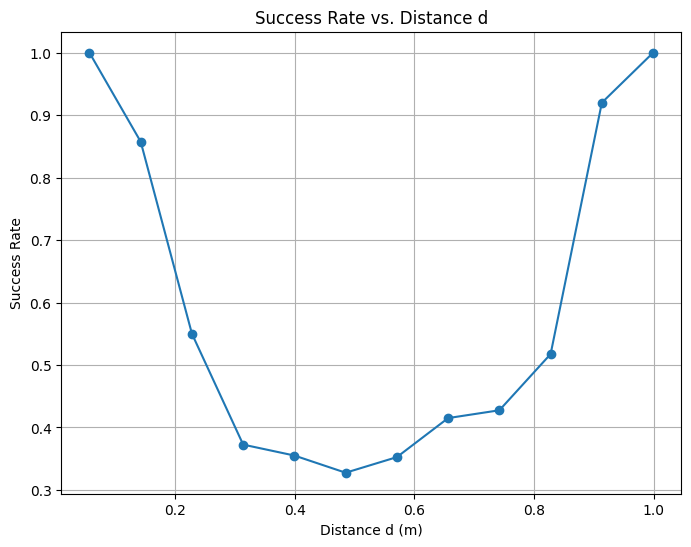

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Vary from 1mm separation between CB and OB to 1mm from pocket's edge
d_values = np.linspace(2.001*cue_ball.params.R, D-0.001, 12)

num_trials = 400
pot_fractions = []

for d in d_values:
    successes = []
    for _ in range(num_trials):
        system = create_system(d, D)
        strike(system, V0, a, phi, theta, dphi=dphi)
        pt.simulate(system, inplace=True)
        success = successful_pot(system)
        successes.append(success)

    pot_fraction = sum(successes) / len(successes)
    pot_fractions.append(pot_fraction)
    print(f"For d = {d:.2f} m, the success rate is {pot_fraction*100:.0f}%.")

plt.figure(figsize=(8, 6))
plt.plot(d_values, pot_fractions, marker='o')
plt.xlabel('Distance d (m)')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Distance d')
plt.grid(True)
plt.show()

Reading left to right, shot success starts high because the OB is close to the CB. But as the OB moves further away from the CB, the success rate decreases, reaching a minimum at around $D/2$. Past this point, the success rate starts to go up again, since the OB is now getting closer and closer to the pocket.

Since this data is generated from a small number of trials, there is some variance in the plot, but if you increase `num_trials` the curve smooths.

## What about skill level?

Since $d\phi$ is a measure of how precise the shot is, it is a reasonable proxy for skill level. With that in mind, how should we expect the shot success trajectory to vary as a function of skill level? Let's repeat the experiment for 3 different skill levels.

Finished dphi=0.15


Finished dphi=0.25


Finished dphi=0.5


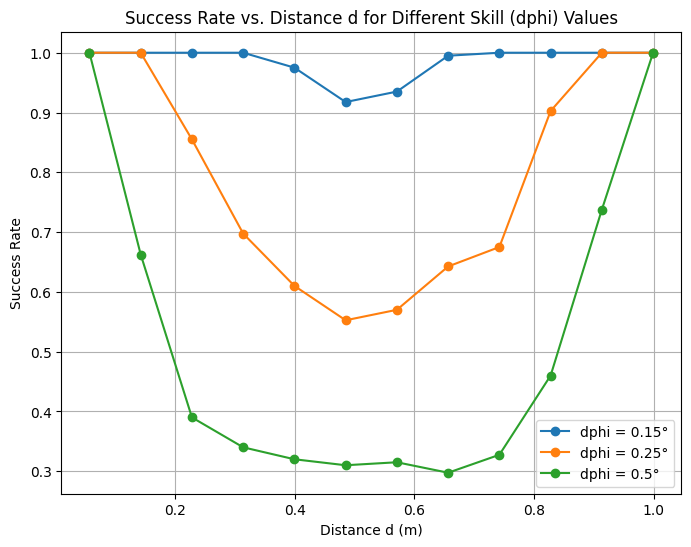

In [12]:
# Define the range of 'd' values you want to test
d_values = np.linspace(2.001 * cue_ball.params.R, D - 0.001, 12)

# Define the range of 'dphi' values (in degrees)
dphi_values = [0.15, 0.25, 0.5]

num_trials = 400
results = {}

for dphi in dphi_values:
    pot_fractions = []
    for d in d_values:
        successes = []
        for _ in range(num_trials):
            system = create_system(d, D)
            strike(system, V0, a, phi, theta, dphi=dphi)
            pt.simulate(system, inplace=True)
            success = successful_pot(system)
            successes.append(success)

        pot_fraction = sum(successes) / len(successes)
        pot_fractions.append(pot_fraction)
        
    print(f"Finished {dphi=}")
    results[dphi] = pot_fractions

plt.figure(figsize=(8, 6))
for dphi in dphi_values:
    plt.plot(d_values, results[dphi], marker='o', label=f'dphi = {dphi}°')

plt.xlabel('Distance d (m)')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Distance d for Different Skill (dphi) Values')
plt.legend()
plt.grid(True)
plt.show()

Regardless of skill level, when $\lim_{d \rightarrow 2R^{+}}$ and $\lim_{d \rightarrow D^{-}}$, the success rate converges to $100\%$. That's expected—when the object ball OB is practically touching the CB or hanging over the pocket, potting becomes nearly automatic for all skill levels. 

But what’s more interesting is observing the extent and sharpness with which success rate drops when the OB is at an intermediate distance $d$. The least skilled players experience the earliest, sharpest, and lowest plummet in sucess rate, whereas high skilled players maintain higher success rate for longer. Yet no matter the skill, the minimum seems to be right at around $d=D/2$.